# 1D FNO Exercise

In [1]:
%config InlineBackend.figure_format = 'svg'
import random
import torch
import sys
import numpy as np
import math
import matplotlib.pyplot as plt
from timeit import default_timer
from scipy.io import loadmat

sys.path.append('../')
from models import FNN1d, FNN_train, construct_model, compute_1dFourier_bases
torch.set_printoptions(precision=16)


# Load data

In [2]:
data_path = "../mytest/data/burgers_data_R10.mat"
data = loadmat(data_path)

data size =  2048  mesh elements =  8192


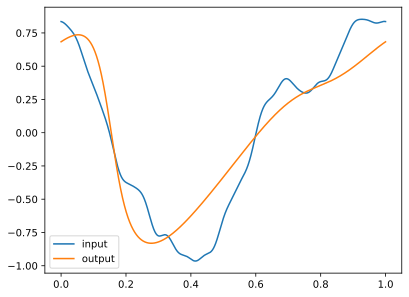

In [3]:
data_in = data["a"]
data_out = data["u"]
print("data size = ", data_in.shape[0], " mesh elements = ", data_in.shape[1])
L = 1
Ne_ref = data_in.shape[1]
grid = np.linspace(0, L, Ne_ref + 1)[:-1]
plt.plot(grid, data_in[0, :], label="input")
plt.plot(grid, data_out[0, :], label="output")
plt.legend()

# 1D Fourier Transform

We compute the Fourier transform for the last dimension of x. We first define the mode set (assume $n_x$ is an even number).

$$K = \{k_x | k_x = 0,1,...,n_x/2-1, -n_x/2, -n_x/2+1, ... -1 \} $$

Then the Fourier transform and inverse Fourier transform give the relation between 
$\{\hat{f}[k_x]: k_x \in K \}$ and $\{f[j_x] : 0 \leq j_x \leq n_x\}$

\begin{align*}
   f(x) &= \frac{1}{n_x} \sum_{k_x \in K}  \hat{f}[k_x]  e^{i k_x \frac{2\pi x}{L_x}} 
   \\ 
   f[j_x] &= \frac{1}{n_x} \sum_{k_x \in K}  \hat{f}[k_x]  e^{i k_x \frac{2\pi j_x \Delta x}{L_x}} 
   \\ 
   \hat{f}[k_x] &= \frac{n_x}{L_x} \int f(x)  e^{-i k_x \frac{2\pi x}{L_x}} dx \\
                &\approx \frac{n_x}{L_x}  \sum_{j_x = 0}^{n_x - 1} f[j_x]  e^{-i k_x \frac{2\pi j_x \Delta x }{L_x}} \Delta x \qquad \textrm{when f has certain form, this is accurate.}\\
                &= \sum_{j_x = 0}^{n_x - 1} f[j_x]  e^{-i k_x \frac{2\pi  j_x}{n_x}}
\end{align*}

When $f(x)$ is real, we have $\hat{f}[k_x] = conj(\hat{f}[-k_x])$, and hence `rfftn` only need to save the subset of $K$ 

$$K^r = \{k_x | k_x = 0,1,...,n_x/2-1, -n_x/2\} $$

For $k_x = 0$ and $-nx/2$, the correponding $\hat{f}[k_x]$ are real numbers. 

When we truncate to first $k_f$ modes, we have 
\begin{align*}
f(x) = \frac{1}{n_x} \Bigl(\hat{f}[0]  \phi_0(x)  +  \sum_{k=1}^{k_f-1}  (\hat{f}[k]  \phi_k(x) + \hat{f}[-k]  \phi_{-k}(x)  )\Bigr)
\end{align*}


In [4]:
# Here is a test, be careful, the torch will generally use float32.
# To get accurate error estimate, use float64

downsample_ratio = 32
n_train = 2**10
x_train = torch.from_numpy(
    np.stack(
        (
            data_in[0:n_train, 0::downsample_ratio],
            np.tile(grid[0::downsample_ratio], (n_train, 1)),
        ),
        axis=-1,
    )
)
batchsize = 16
x = x_train[0:batchsize]
x = x.permute(0, 2, 1)
x_ft = torch.fft.rfftn(x, dim=[2])
print(" The shape of x is ", x.shape, " the shape of x_ft is ", x_ft.shape)

n_b, n_c, n_x = x.shape
assert n_x % 2 == 0
n_k = n_x // 2

x = x.to(torch.complex128)


# Implementation 1
Kr = list(range(0, n_k)) + [-n_k]
x_ft2 = torch.zeros(n_b, n_c, n_k + 1, dtype=torch.complex128)
for j_k in range(n_k + 1):
    basis = torch.exp(
        (
            -Kr[j_k]
            * 2
            * np.pi
            / n_x
            * 1.0j
            * torch.linspace(0, n_x - 1, n_x, dtype=torch.float64)
        )
    )
    x_ft2[:, :, j_k] += torch.einsum("bcx,x->bc", x, basis)
print("Error between x_ft and x_ft2 is ", torch.norm(x_ft - x_ft2))

# Implementation 2
Kr = torch.tensor(list(range(0, n_k)) + [-n_k], dtype=torch.float64)
bases = torch.exp(
    torch.outer(
        torch.linspace(0, n_x - 1, n_x, dtype=torch.float64),
        -2 * np.pi / n_x * 1.0j * Kr,
    )
)
x_ft2 = torch.einsum("bcx,xk->bck", x, bases)
print("Error between x_ft and x_ft2 is ", torch.norm(x_ft - x_ft2))

 The shape of x is  torch.Size([16, 2, 256])  the shape of x_ft is  torch.Size([16, 2, 129])
Error between x_ft and x_ft2 is  tensor(7.4921795743786390e-12, dtype=torch.float64)
Error between x_ft and x_ft2 is  tensor(7.5010232622467314e-12, dtype=torch.float64)


In [5]:
x_ift = torch.fft.irfftn(x_ft, dim=[2])
print("Error between x and x_ift is ", torch.norm(x - x_ift))

modes = 6
#  Truncate to the first m modes
x_ft_trunc = torch.zeros(n_b, n_c, n_k + 1, dtype=torch.complex128)
x_ft_trunc[:, :, :modes] = x_ft[:, :, :modes]

x_ift_trunc = torch.fft.irfftn(x_ft_trunc, dim=[2])

# Implementation 1
Kr = torch.tensor(list(range(0, n_k)) + [-n_k], dtype=torch.float64)
bases = torch.exp(
    torch.outer(
        torch.linspace(0, n_x - 1, n_x, dtype=torch.float64),
        2 * np.pi / n_x * 1.0j * Kr,
    )
)
bases[:, 1:-1] *= 2.0
x_ift2 = torch.real(torch.einsum("bck,xk->bcx", x_ft_trunc, bases)) / n_x
print("Error between x and x_ift2 is ", torch.norm(x_ift_trunc - x_ift2))

# Implementation 2
Kr = torch.tensor(list(range(0, modes)), dtype=torch.float64)
bases = torch.exp(
    torch.outer(
        torch.linspace(0, n_x - 1, n_x, dtype=torch.float64),
        2 * np.pi / n_x * 1.0j * Kr,
    )
)
bases[:, 1:] *= 2.0
x_ift2 = torch.real(torch.einsum("bck,xk->bcx", x_ft_trunc[:, :, :modes], bases)) / n_x
print("Error between x and x_ift2 is ", torch.norm(x_ift_trunc - x_ift2))

Error between x and x_ift is  tensor(1.0326249833177797e-14, dtype=torch.float64)
Error between x and x_ift2 is  tensor(1.7990696088728546e-14, dtype=torch.float64)
Error between x and x_ift2 is  tensor(1.7990696088728546e-14, dtype=torch.float64)


# Spectral Transform

We compute the spectral transform for the last dimension of x. 
We first define $n_k$ orthonal bases $\{ \phi_k \}_{k = 0}^{n_k-1}$


Then the spectral transform and inverse spectral transform give the relation between 
$\{\hat{f}[k]: k \in K \}$ and $\{f(x_j) : 0 \leq j \leq n_x\}$

\begin{align*}
   f(x) &= \sum_{k=0}^{n_k-1}  \hat{f}[k]  \phi_k(x) 
   \\ 
   f(x_j) &= \sum_{k_x=0}^{n_k-1}  \hat{f}[k]  \phi_k(x_j)
   \\ 
   \hat{f}[k] &= \int f(x)  \phi_k(x) dx\\
                &= \sum_{j = 0}^{n_x}  f(x_j)  \phi_k(x_j) \Delta x_j
\end{align*}
Here $\phi_k(x)$ are orthogonal bases with $$\int \phi_i(x) \overline{\phi_k(x)} dx = \delta_{ik},$$ and at the discrete level
$$\sum_{j = 0}^{n_x} \phi_i(x_j) \overline{\phi_j(x_j)} \Delta x_j = \delta_{ik}$$



We set bases 
\begin{equation}
B = 
\begin{bmatrix}
\phi_0(x_j)  & \phi_1(x_j)  &  \cdots &  \phi_{n_k-1}(x_j)  
\end{bmatrix}
\end{equation}
and weighted bases 
\begin{equation}
B = 
\begin{bmatrix}
\phi_0(x_j) \Delta x_j  & \phi_1(x_j) \Delta x_j &  \cdots &  \phi_{n_k-1}(x_j) \Delta x_j
\end{bmatrix}
\end{equation}

To recover 1D Fourier Transform, we set 

$$\phi_k(x) = \frac{1}{\sqrt{L_x}},\, \frac{\sqrt{2}}{\sqrt{L_x}}\cos(\frac{2\pi  x}{L_x}), \frac{\sqrt{2}}{\sqrt{L_x}}\sin(\frac{2\pi  x}{L_x}), \cdots \frac{\sqrt{2}}{\sqrt{L_x}}\cos(\frac{2k\pi x}{L_x}), \frac{\sqrt{2}}{\sqrt{L_x}}\sin(\frac{2k\pi x}{L_x}),\cdots $$



In [6]:
torch.manual_seed(0)
np.random.seed(0)

downsample_ratio = 16

L = 1.0
Ne_ref = data_in.shape[1]
grid = np.linspace(0, L, Ne_ref + 1)[:-1]

n_train = n_test = 2**10
x_train = torch.from_numpy(
    np.stack(
        (
            data_in[0:n_train, 0::downsample_ratio],
            np.tile(grid[0::downsample_ratio], (n_train, 1)),
        ),
        axis=-1,
    ).astype(np.float32)
)
y_train = torch.from_numpy(
    data_out[0:n_train, 0::downsample_ratio, np.newaxis].astype(np.float32)
)
x_test = torch.from_numpy(
    np.stack(
        (
            data_in[-n_test:, 0::downsample_ratio],
            np.tile(grid[0::downsample_ratio], (n_train, 1)),
        ),
        axis=-1,
    ).astype(np.float32)
)
y_test = torch.from_numpy(
    data_out[-n_test:, 0::downsample_ratio, np.newaxis].astype(np.float32)
)

## Choose the Basis

In [7]:
k_max = 33
basis_type = "Fourier_bases"

if basis_type == "Fourier_bases":
    Ne = Ne_ref // downsample_ratio
    grid, fbases, weights = compute_1dFourier_bases(Ne, k_max, L)
    wfbases = fbases * np.tile(weights, (k_max, 1)).T
    bases = torch.from_numpy(fbases.astype(np.float32))
    wbases = torch.from_numpy(wfbases.astype(np.float32))
    model_type = "GalerkinNO"

elif basis_type == "Galerkin_bases":
    Ne = Ne_ref // downsample_ratio
    pca_data = data_out[0:n_train, 0::downsample_ratio]
    pca_include_input = False
    pca_include_grid = False
    if pca_include_input:
        pca_data = np.vstack((pca_data, data_in[0:n_train, 0::downsample_ratio]))
    if pca_include_grid:
        n_grid = 1
        pca_data = np.vstack(
            (pca_data, np.tile(grid[0::downsample_ratio], (n_grid, 1)))
        )
    U, S, VT = np.linalg.svd(pca_data.T)
    # the integration of the basis is 1.
    fbases = U[:, 0:k_max] / np.sqrt(L / Ne)
    wfbases = L / Ne * fbases
    bases = torch.from_numpy(fbases.astype(np.float32))
    wbases = torch.from_numpy(wfbases.astype(np.float32))
    model_type = "GalerkinNO"

else:
    print("Bases construction error")

## Configs

In [10]:
model_type = "GalerkinNO"
galerkin_config_std = {
    "type": "GalerkinConv",
    "num_modes": k_max,
    "bases": bases,
    "wbases": wbases,
}
fourier_config_std = {
    "type": "FourierConv",
    "num_modes": k_max // 2,
}
attention_config_std = {
    "type": "Attention",
    "num_heads": 1,
    "attention_type": "galerkin",
}
layer_configs = [fourier_config_std, galerkin_config_std, attention_config_std]


config = {
    "model": {
        "model": model_type,
        "dim": 1,
        "fc_dim": 128,
        "layers": [64] * 4,
        "in_dim": 2,
        "out_dim": 1,
        "act": "gelu",
        "pad_ratio": -1,
        "layer_configs": layer_configs,
    },
    "train": {
        "base_lr": 0.001,
        "weight_decay": 1.0e-4,
        "epochs": 1000,
        "scheduler": "MultiStepLR",
        "milestones": [200, 300, 400, 500, 800, 900],
        "scheduler_gamma": 0.5,
        "batch_size": 8,
        "normalization_x": True,
        "normalization_y": True,
        "normalization_dim": [],
    },
}


model = construct_model(config, bases, wbases)
print(model)

GkNN(
  (fc0): Linear(in_features=2, out_features=64, bias=True)
  (sp_layers): ModuleList(
    (0): SpectralConv1d()
    (1): GalerkinConv()
    (2): SimpleAttention(
      (linears): ModuleList(
        (0-2): 3 x Linear(in_features=64, out_features=64, bias=True)
      )
      (fc): Linear(in_features=64, out_features=64, bias=True)
      (norm_K): ModuleList(
        (0): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
      (norm_V): ModuleList(
        (0): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
    )
  )
  (ws): ModuleList(
    (0-2): 3 x Conv1d(64, 64, kernel_size=(1,), stride=(1,))
  )
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)


In [9]:
print("Start training ", config["model"]["model"])
train_rel_l2_losses, test_rel_l2_losses, test_l2_losses = FNN_train(
    x_train,
    y_train,
    x_test,
    y_test,
    config,
    model,
    save_model_name="../models/save/test.pth",
)

Start training  GalerkinNO
Epoch :  0  Rel. Train L2 Loss :  0.16452278455835767  Rel. Test L2 Loss :  0.052851608430501074  Test L2 Loss :  0.025494802233879454
Epoch :  1  Rel. Train L2 Loss :  0.04140013220603578  Rel. Test L2 Loss :  0.03663938710815273  Test L2 Loss :  0.01699718401505379


KeyboardInterrupt: 